## Notebook d'essais - Projet 4 - David Depouez

### 1. Importation et selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from sklearn.utils import resample
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


variables de configuration pour le script

In [2]:
sampleSizeUsed = 1
sampleSizeUsed = 0.60

# use feature delay or not
useDelay = True

useSilhouette = True
# just performs kmeans 2,3,4 instead of up to 9 ?
kmeansLowProcessing = False

# one pass for each algo
useFastTest = False

# useBypassTest to only process kmeans
useBypassTest = False

# agglo failed on local notebook and work only with kaggle ????
useAgglo = True
useDbscan = True

if useBypassTest == True:
    useAgglo = False
    useDbscan = False

In [3]:
path = "./data/cleaned/"

filename = 'Cleaned-V4-Full.csv'

# for kagle use only
filename = "/kaggle/input/d/daviddepouez/cleaned-v4-full/Cleaned-V4-Full.csv"
path = ""

df = pd.read_csv(path + filename,low_memory=False)

Une fonction d'analyse des colonnes d'un dataframe

In [4]:
def getCompCols(df,cols):
    ### Get complements colons of cols for a dataframe df ###
    ComplementCols =  [name for i,name in enumerate(df.columns) if name not in cols]
    return ComplementCols

In [5]:
print(df.shape)
df.head()

(96096, 7)


,Frequency,Recency,retard,delai,Monetary,review_score,word_number
0,1,1818,-5.0,6.0,141.90,5.0,20.0
1,1,1821,-5.0,3.0,27.19,4.0,0.0
2,1,2244,-2.0,25.0,86.22,3.0,0.0
3,1,2028,-12.0,20.0,43.62,4.0,2.0
4,1,1995,-8.0,13.0,196.89,5.0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Frequency     96096 non-null  int64  
 1   Recency       96096 non-null  int64  
 2   retard        96096 non-null  float64
 3   delai         96096 non-null  float64
 4   Monetary      96096 non-null  float64
 5   review_score  96096 non-null  float64
 6   word_number   96096 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 5.1 MB


In [7]:
df.describe()

,Frequency,Recency,retard,delai,Monetary,review_score,word_number
count,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000
mean,1.034809,1946.000770,-11.499269,12.466519,166.593897,4.085016,4.980218
std,0.214384,153.413183,10.184498,9.808022,231.427730,1.336371,8.791781
min,1.000000,1658.000000,-147.000000,0.000000,0.000000,1.000000,0.000000
25%,1.000000,1822.000000,-17.000000,6.000000,63.120000,4.000000,0.000000
50%,1.000000,1927.000000,-12.000000,10.000000,108.000000,5.000000,0.000000
75%,1.000000,2055.000000,-7.000000,16.000000,183.530000,5.000000,7.000000
max,17.000000,2431.000000,188.000000,209.000000,13664.080000,5.000000,121.000000


In [8]:
if useDelay == False:
    df.drop('delai',axis=1,inplace=True)

Les histogrammes des differentes features

array([[<AxesSubplot: title={'center': 'Frequency'}>,
        <AxesSubplot: title={'center': 'Recency'}>,
        <AxesSubplot: title={'center': 'retard'}>],
       [<AxesSubplot: title={'center': 'delai'}>,
        <AxesSubplot: title={'center': 'Monetary'}>,
        <AxesSubplot: title={'center': 'review_score'}>],
       [<AxesSubplot: title={'center': 'word_number'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

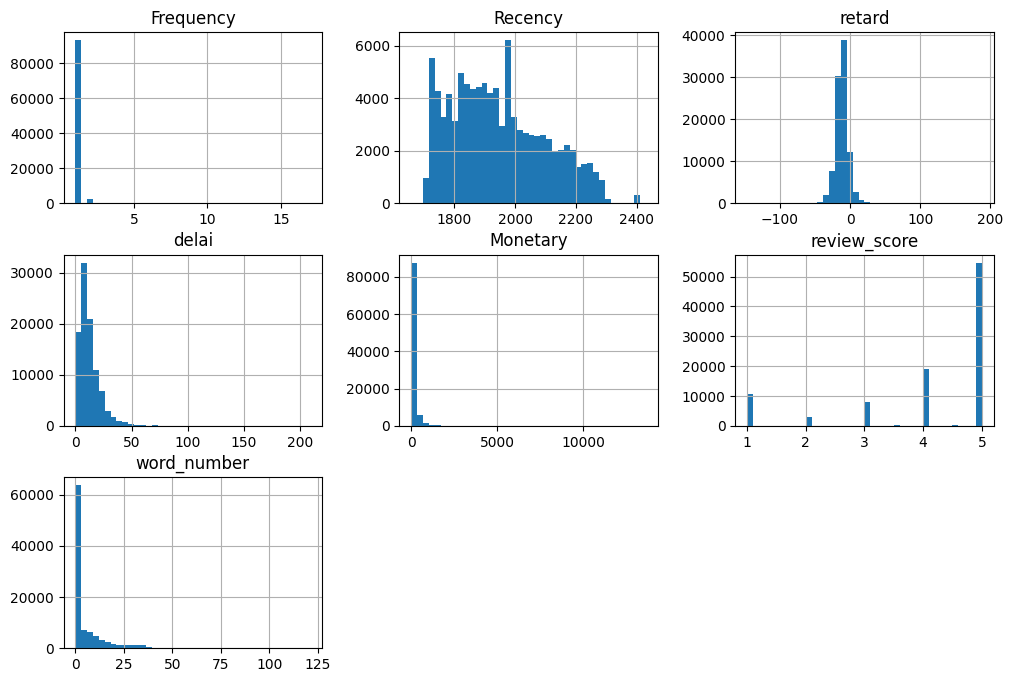

In [9]:
df.hist(bins=40,figsize = (12,8))

Des fonctions pour gérer les outliers

In [10]:
# Functions to handle outliers
def getQuantiles(dFrame,colName,lower=0.25,higher=0.75,isLog=False) :
    ### Get values corresponding to quartiles (defaults are for Q1 and Q3)###
    low,high = dFrame[colName].quantile([lower,higher])
    if isLog == True:
        print("For quantile {} val={:2.3} and for quantile {} val={:2.3}".format(lower,low,higher,high))
    return (low,high)

def computeTukeyMinMax(dFrame,colName,lower=0.25,higher=0.75, whis=1.5,isLog=False, minValue = 0.0) :
    ### Get min and max corresponding to Tukey's Law (default whis is 1.5)###
    Q1, Q3 = getQuantiles(dFrame,colName,lower=lower,higher=higher)
    IQR = Q3 - Q1
    
    vmin = Q1 - whis*IQR
    if vmin < minValue :
        vmin = minValue
    
    vmax = Q3 + whis*IQR
    if isLog == True:
        print("Q1 {:2.3} Q3 {:2.3} IQR {:2.3} vmin {:2.3} vmax {:2.3}".format(Q1,Q3,IQR,vmin,vmax))
    return (vmin,vmax)

def displayOutliers(dFrame,colName,isDump=False,isLog=False, minValue = 0.0) :
    ### Display outliers and according boxplot based on Tukey's law ###
    vmin, vmax = computeTukeyMinMax(dFrame,colName,minValue)
    mask = (dFrame[colName] > vmax) | (dFrame[colName] < vmin)
    nbOutliers = len(dFrame.loc[mask == True , :])
    if nbOutliers != 0 and isDump == True:
        display(dFrame.loc[mask == True ,[colName]].sort_values(by=colName,ascending=False))
    dFrame.boxplot(column = colName, grid = False)
    if isLog == True:
        print("{} Outliers, vmin {:2.3} vmax {:2.3}".format(nbOutliers,vmin,vmax))
    return (vmin,vmax,nbOutliers)

#dFrame[colName].clip(lower=low,upper=up,inplace=True)

Les boxplots des features

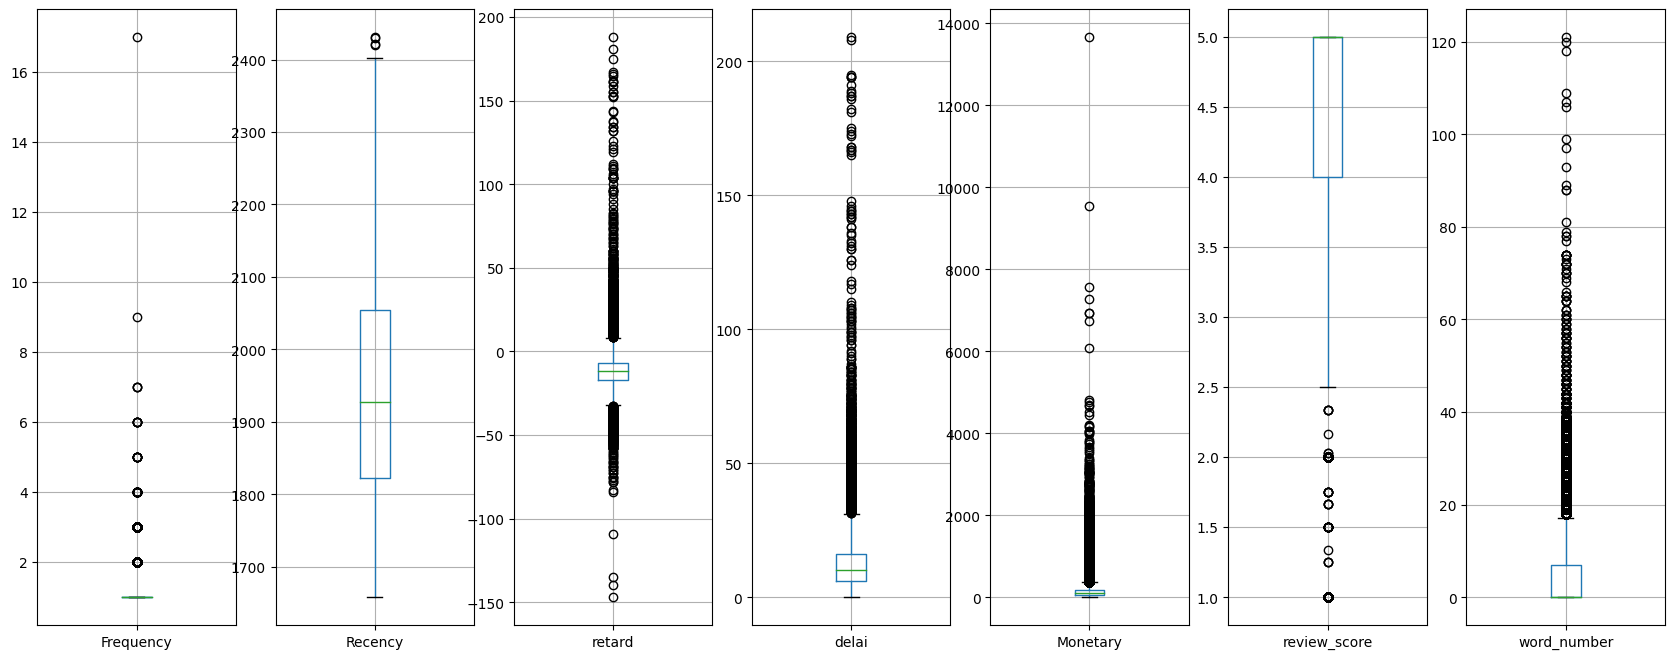

In [11]:
if useDelay == True:
    fig, axes = plt.subplots(1,7,figsize=(21, 8))
    cols = df.columns
else:
    fig, axes = plt.subplots(1,6,figsize=(21, 8))
    cols = getCompCols(df,'delai')
    
for i,el in enumerate(cols):
    #a = df.boxplot(el, ax=axes.flatten()[i])
    #valMin, valMax, nbOutliers = displayOutliers(df,el)
    a = df.boxplot(el, ax=axes.flatten()[i])

plt.show()

Reduction des outliers

In [12]:
if useDelay == True:
    keep = ['Monetary','retard', 'word_number','delai']
else:
    keep = ['Monetary','retard','word_number']

for i in keep:
    print(i)
    valMin, valMax = computeTukeyMinMax(df,i,isLog=True,higher=0.85,lower=0.15,minValue=df[i].min())
    print(valMin, valMax)
    df[i].clip(lower=valMin,upper=valMax,inplace=True)

Monetary
Q1 47.6 Q3 2.48e+02 IQR 2.01e+02 vmin 0.0 vmax 5.5e+02
0.0 549.505
retard
Q1 -20.0 Q3 -3.0 IQR 17.0 vmin -45.5 vmax 22.5
-45.5 22.5
word_number
Q1 0.0 Q3 12.0 IQR 12.0 vmin 0.0 vmax 30.0
0.0 30.0
delai
Q1 5.0 Q3 20.0 IQR 15.0 vmin 0.0 vmax 42.5
0.0 42.5


Impossible de faire tourner l'algorithme de clustering hierarchique ni en local ni sur kaggle a cause de la memoire requise. Creation alors d'une fonction pour recuperer aleatoirement un sous echantillon du dataframe 

In [13]:
def getShuffleIndices(lenData,splitNumber):
    """ Split randomly data(list,array).
    If splitNumber > 1 then split in equal part rounded and if < 1 split in two part as percentage
    return a list containing the list of shuffled indices.
    """
    print("Processing getShuffleIndices with splitNumber = {}".format(splitNumber))
    
    begin = 0
    splitIndiceLists = []
    indicesList = np.random.permutation(lenData)
    
    if splitNumber >= 1:
        sampleSize = round(lenData / splitNumber)
        print("1 length {} sampleSize {}".format(lenData,sampleSize))
        for i in range(1,splitNumber+1):
            end = i*sampleSize
            if i == splitNumber:
                end = lenData
            #print(i,begin,end)
            splitIndiceLists.append(indicesList[begin:end])
            begin = end
        
    else :
        sampleSize = round(lenData * splitNumber)
        print("2 length {} sampleSize {}".format(lenData,sampleSize))
        splitIndiceLists.append(indicesList[0:sampleSize])
        splitIndiceLists.append(indicesList[sampleSize:])
    
    return splitIndiceLists

In [14]:
dfCopy = df.copy()

Centrage et mise à l'echelle des datas completes et reduites (on garde les completes pour faire une analyse PCA)

In [15]:
scaler = StandardScaler()

# XFull       : values from the original DataFrame df
# XFullScaled : XFull scaled
# XReduct     : selected sample from XFull
# XScaled     : XReduct scaled
# X           : copy from XScaled used in each algorithm

XFull = df.to_numpy()
XFullScaled = scaler.fit_transform(XFull)
colNames = dfCopy.columns
dfIndexes = dfCopy.index
print("XFull ",XFull.shape)

XReductIndexList = getShuffleIndices(len(XFull),sampleSizeUsed)
XReductIndex = XReductIndexList[0]

XReduct = XFull[XReductIndex,:]
print("XReduct ",XReduct.shape)

XScaled = scaler.fit_transform(XReduct)
print("XScaled ",XScaled.shape)


# return to dataframe ....
#dfScaled = pd.DataFrame(XScaled,columns=colNames)

XFull  (96096, 7)
Processing getShuffleIndices with splitNumber = 0.6
2 length 96096 sampleSize 57658
XReduct  (57658, 7)
XScaled  (57658, 7)


### 2. ACP

In [16]:
X = XFullScaled.copy()

pca = PCA()
pca.fit_transform(X)

array([[ 0.2098359 ,  0.39223305,  0.47305609, ..., -0.00970639,
        -1.69074195, -0.58946373],
       [-0.57337776, -0.91074851,  0.95465232, ...,  0.50628413,
         0.31928261, -0.90604802],
       [ 1.60423145, -1.16191433, -1.26602545, ...,  0.55254997,
         0.39870006, -0.10826222],
       ...,
       [-1.42258355, -0.00360671, -2.31389768, ...,  0.16252164,
         0.26812913,  0.97359867],
       [ 0.12628485,  0.62985954,  0.02574973, ..., -0.07344275,
        -1.60966851,  0.44627592],
       [-1.17346123, -0.50856134, -1.3629406 , ...,  0.4958725 ,
        -0.05944702, -0.37358865]])

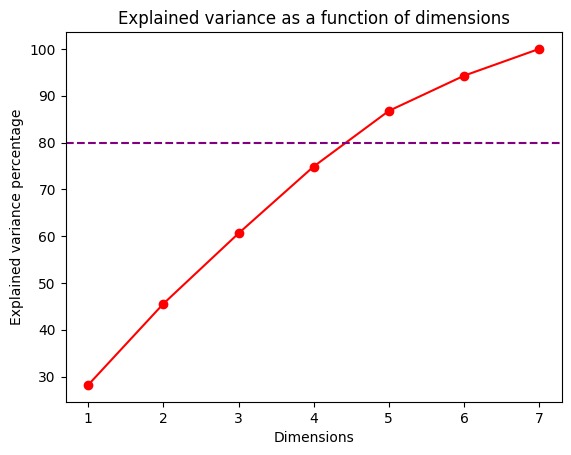

In [17]:
scree = (pca.explained_variance_ratio_*100).round(2)
screeCum = scree.cumsum()
x_list = list(range(1, len(scree) +1))
plt.plot(x_list, screeCum,c='red',marker='o')
plt.axhline(y=80,color='purple',linestyle='dashed')
plt.xlabel("Dimensions")
plt.ylabel("Explained variance percentage")
plt.title("Explained variance as a function of dimensions")
#pl.legend()
plt.show(block=False)

On projette sur deux composantes principales pour eventuellement avoir une representation visuelle des clusters

In [18]:
pca = PCA(n_components = 2)

In [19]:
XProjected = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.2821726  0.17331158]
0.4554841844969547


In [20]:
pca.components_

array([[ 0.03748143,  0.04240962,  0.50695112,  0.55750432,  0.11617146,
        -0.53648011,  0.35732247],
       [ 0.62622931, -0.02429547, -0.29641079, -0.15863409,  0.61534313,
        -0.04546816,  0.33690938]])

In [21]:
for i,(x,y) in enumerate(zip(XProjected[:,0],XProjected[:,1])):
    print(i,x,y)
    if i > 5:
        break

0 0.20983590049481973 0.39223304646331314
1 -0.5733777639948232 -0.9107485092786459
2 1.6042314492207754 -1.1619143318940808
3 0.31611203749179234 -0.8721816720198681
4 -0.2804535625034634 -0.23477915498637883
5 -0.9508930906587334 0.027748269956483523
6 -0.7488704288913949 -0.7047860908486359


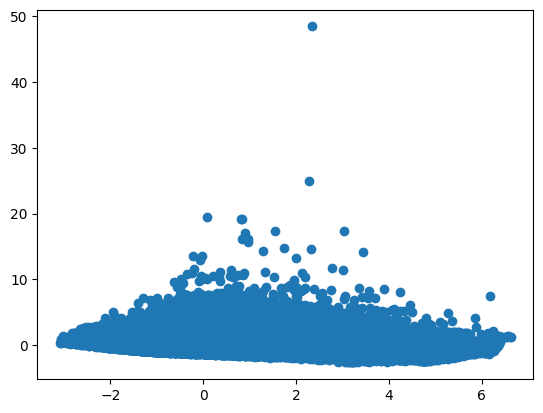

In [22]:
#plt.scatter(XProjected[:, 0], XProjected[:, 1],c=kmeans.labels_)
plt.scatter(XProjected[:, 0], XProjected[:, 1])

#plt.xlim([-10, 50])
#plt.ylim([-10, 50])
#plt.colorbar()

Cercle de correlation

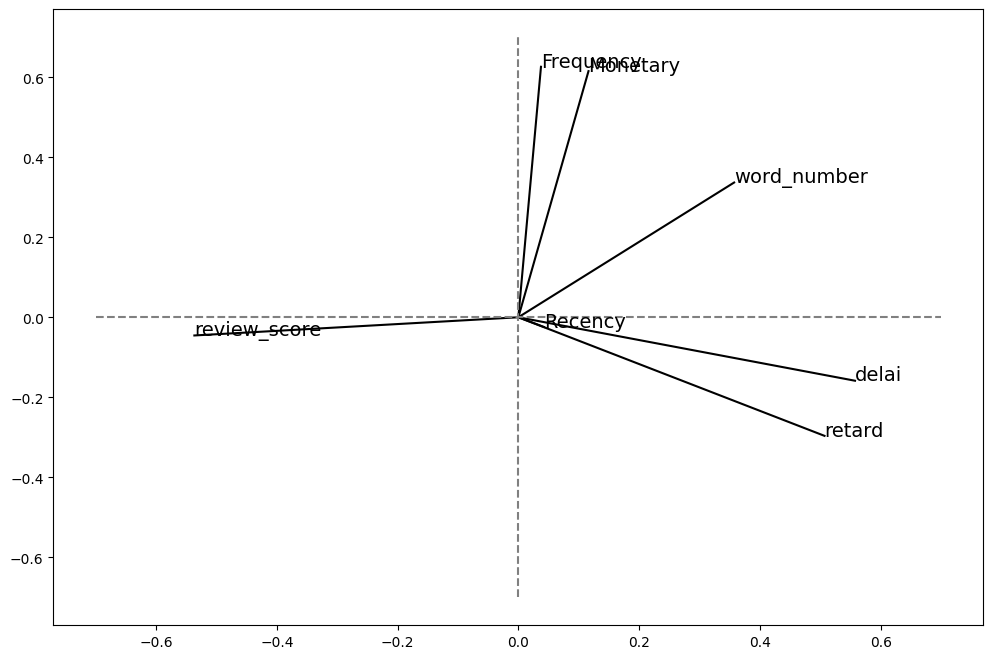

In [23]:
pcs = pca.components_

plt.figure(figsize=(12, 8))

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, colNames[i], fontsize='14')

# Afficher une ligne horizontale y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')

#plt.xlim([-0.7, 0.7])
#plt.ylim([-0.7, 0.7])
plt.show()

On cree un dataframe pour enregistrer les valeurs maximum du coefficient silhouette par algorithme

In [24]:
# dataframe to store best silhouette score for each algorithm
dfScore = pd.DataFrame([[np.NaN,np.NaN,np.NaN]],index=['Silhouette Score'],columns=['KMEANS','DBSCAN','AGGLOMERATIVE'])
dfScore

,KMEANS,DBSCAN,AGGLOMERATIVE
Silhouette Score,NaN,NaN,NaN


### 3. Modélisations

#### KMeans

In [25]:
X = XScaled.copy()

on effectue kmeans pour differents parametres et on calcul le score silhouette correspondant.

In [26]:
if kmeansLowProcessing == True:
    maxClusters = 4
else:
    maxClusters = 10

if useFastTest == True:
    maxClusters = 2
    
kListe = list(range(2,maxClusters+1))
    
kmeansInertia = []
kmeansSilhouette = []

for k in kListe:
    kmeans = KMeans(n_clusters=k,init='k-means++',n_init=10)
    print("Processing KMEANS with K={}".format(k))
    kmeans.fit(X)
    #kmeans.fit_predict(X)
    kmeansInertia.append(kmeans.inertia_)
    if useSilhouette == True:
        print("Processing silhouette score ...")
        silhScore = silhouette_score(X, kmeans.labels_,n_jobs=-1)
        print("... silhouette score = {}".format(silhScore))
        kmeansSilhouette.append(silhScore)        

Processing KMEANS with K=2
Processing silhouette score ...
... silhouette score = 0.34618519450953905
Processing KMEANS with K=3
Processing silhouette score ...
... silhouette score = 0.36053660690321754
Processing KMEANS with K=4
Processing silhouette score ...
... silhouette score = 0.1909592159142803
Processing KMEANS with K=5
Processing silhouette score ...
... silhouette score = 0.20734444952830733
Processing KMEANS with K=6
Processing silhouette score ...
... silhouette score = 0.22369503941834482
Processing KMEANS with K=7
Processing silhouette score ...
... silhouette score = 0.22055337809289824
Processing KMEANS with K=8
Processing silhouette score ...
... silhouette score = 0.2257338209984076
Processing KMEANS with K=9
Processing silhouette score ...
... silhouette score = 0.20131855240737045
Processing KMEANS with K=10
Processing silhouette score ...
... silhouette score = 0.20255261408048333


Representation de l'inertie

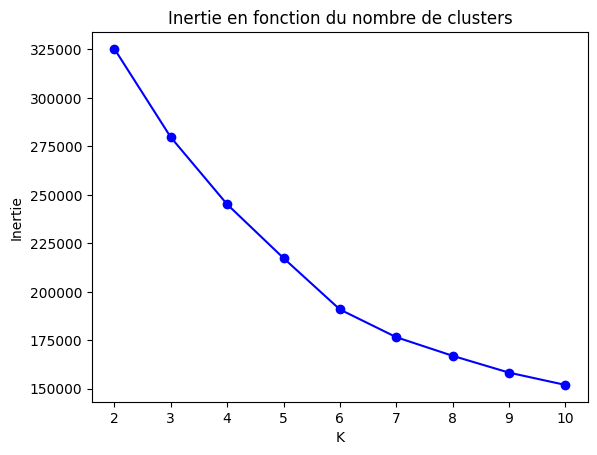

In [27]:
plt.plot(kListe, kmeansInertia,c='blue',marker='o')
plt.xlabel("K")
plt.ylabel("Inertie")
plt.title("Inertie en fonction du nombre de clusters")
#pl.legend()
plt.show(block=False)

Representation de silhouette

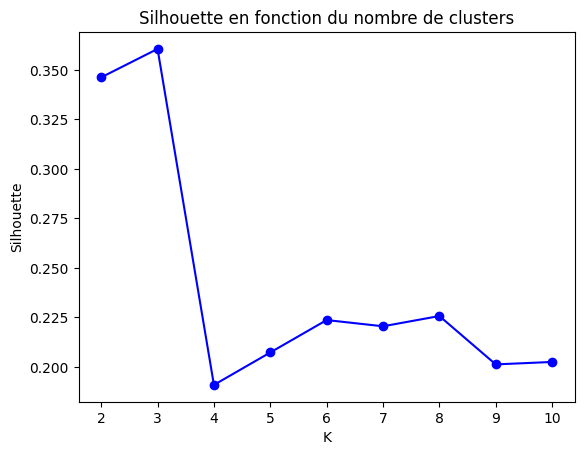

In [28]:
if useSilhouette == True:
    plt.plot(kListe, kmeansSilhouette,c='blue',marker='o')
    plt.xlabel("K")
    plt.ylabel("Silhouette")
    plt.title("Silhouette en fonction du nombre de clusters")
    #pl.legend()
    plt.show(block=False)

Selection du meilleur score

In [29]:
kmeansBestParams = [max(kmeansSilhouette),kmeansSilhouette.index(max(kmeansSilhouette)) + 2]
print("Kmeans best cluster found is :", kmeansBestParams[1])
dfScore['KMEANS'] = kmeansBestParams[0]

Kmeans best cluster found is : 3


In [30]:
dfScore.head()

,KMEANS,DBSCAN,AGGLOMERATIVE
Silhouette Score,0.360537,NaN,NaN


#### DBSCAN

In [31]:
X = XScaled.copy()

In [32]:
epsilonList = [0.05,0.1]
minSampleList = [5,10]

DBScanSilhouette = []

if useFastTest == True:
    epsilonList = [0.05]
    minSampleList = [5]

if useBypassTest == True:
    useSilhouette = False
    
if useBypassTest == False and useDbscan == True:
    for epsilon in epsilonList:
        for minSample in minSampleList:
            dbscan = DBSCAN(eps=epsilon, min_samples=minSample,n_jobs=-1)
            print("Processing DBSCAN with eps={} and minSample={} ".format(epsilon,minSample))
            #dbscan.fit_predict(X)
            dbscan.fit(X)
            labels = dbscan.labels_
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise_ = list(labels).count(-1)
            print("... found {} clusters with {} noise points".format(n_clusters_,n_noise_))
            if useSilhouette == True:
                print("Processing silhouette score ...")
                if len(np.unique(dbscan.labels_)) > 1:
                    silhScore = silhouette_score(X, dbscan.labels_,n_jobs=-1)
                else:
                    silhScore = -1
                print("... silhouette score = {}".format(silhScore))
                a = (silhScore, n_clusters_,epsilon, minSample,n_noise_)
                DBScanSilhouette.append(a)

Processing DBSCAN with eps=0.05 and minSample=5 
... found 1 clusters with 57652 noise points
Processing silhouette score ...
... silhouette score = -0.11313758956230992
Processing DBSCAN with eps=0.05 and minSample=10 
... found 0 clusters with 57658 noise points
Processing silhouette score ...
... silhouette score = -1
Processing DBSCAN with eps=0.1 and minSample=5 
... found 81 clusters with 57145 noise points
Processing silhouette score ...
... silhouette score = -0.4947524257215863
Processing DBSCAN with eps=0.1 and minSample=10 
... found 0 clusters with 57658 noise points
Processing silhouette score ...
... silhouette score = -1


In [33]:
if useSilhouette == True and useDbscan == True:
    bestDBScanIndex = DBScanSilhouette.index(max(DBScanSilhouette))
    dbscanBestParams = DBScanSilhouette[bestDBScanIndex]
    print(dbscanBestParams[0],dbscanBestParams[1],dbscanBestParams[2],dbscanBestParams[3],dbscanBestParams[4])
    dfScore['DBSCAN'] = dbscanBestParams[0]
else:
    dbscanBestParams = [-1,0,0.05,5,0]
    dfScore['DBSCAN'] = dbscanBestParams[0]

-0.11313758956230992 1 0.05 5 57652


In [34]:
dfScore.head()

,KMEANS,DBSCAN,AGGLOMERATIVE
Silhouette Score,0.360537,-0.113138,NaN


#### AgglomerativeClustering

In [35]:
X = XScaled.copy()

In [36]:
maxClusters = 5
kListe = list(range(2,maxClusters+1))

if useFastTest == True:
    kListe = [2]

AggloSilhouette = []

if useBypassTest == False and useAgglo == True:
    for k in kListe:
        clustering = AgglomerativeClustering(n_clusters=k)
        print("Processing AGGLOMERATIVE with n_clusters={}".format(k))
        #clustering.fit_predict(X)
        clustering.fit(X)
        if useSilhouette == True:
            print("Processing silhouette score ...")
            silhScore = silhouette_score(X, clustering.labels_,n_jobs=-1)
            print("... silhouette score = {}".format(silhScore))
            AggloSilhouette.append(silhScore)        

Processing AGGLOMERATIVE with n_clusters=2
Processing silhouette score ...
... silhouette score = 0.31116462287585767
Processing AGGLOMERATIVE with n_clusters=3
Processing silhouette score ...
... silhouette score = 0.339815221143139
Processing AGGLOMERATIVE with n_clusters=4
Processing silhouette score ...
... silhouette score = 0.23374379171382978
Processing AGGLOMERATIVE with n_clusters=5
Processing silhouette score ...
... silhouette score = 0.24331954624167187


In [37]:
if useBypassTest == False and useAgglo == True:
    aggloBestParams = [max(AggloSilhouette),AggloSilhouette.index(max(AggloSilhouette)) + 2]
    print("Agglo best cluster found is :", aggloBestParams[1])
    dfScore['AGGLOMERATIVE'] = aggloBestParams[0]
else:
    dfScore['AGGLOMERATIVE'] = -1

Agglo best cluster found is : 3


#### selection du meilleur algorithme

In [38]:
dfScore = dfScore.transpose()
dfScore

,Silhouette Score
KMEANS,0.360537
DBSCAN,-0.113138
AGGLOMERATIVE,0.339815


On determine le meilleur candidat et ses parametres

In [39]:
bestAlgoFound = dfScore.idxmax().to_string().split()
bestAlgoFound = bestAlgoFound[-1]

In [40]:
if bestAlgoFound == 'KMEANS':
    clusterNumber = kmeansBestParams[1]
    handle = KMeans(n_clusters=clusterNumber,init='k-means++',n_init=10)
elif bestAlgoFound =='DBSCAN':
        clusterNumber = dbscanBestParams[1]
        handle = DBSCAN(eps=dbscanBestParams[2] , min_samples=dbscanBestParams[3], n_jobs=-1)

else:
        clusterNumber = aggloBestParams[1]
        handle = AgglomerativeClustering(n_clusters=aggloBestParams[1])
        
print('Best algo found is {} with {} clusters'.format(bestAlgoFound,clusterNumber))

Best algo found is KMEANS with 3 clusters


On reconstitue le dataframe reduit

In [41]:
# Construct the Reduct DataFrame
dfReduct = pd.DataFrame(XReduct,index=XReductIndex,columns=colNames)
dfReduct.head()

,Frequency,Recency,retard,delai,Monetary,review_score,word_number
23422,1.0,1748.0,-28.0,8.0,118.49,1.0,14.0
52712,1.0,1720.0,-16.0,5.0,42.22,4.0,0.0
28265,1.0,2015.0,-4.0,12.0,113.44,5.0,0.0
80317,1.0,1898.0,-11.0,3.0,179.34,5.0,0.0
32635,1.0,1800.0,-12.0,4.0,37.77,5.0,0.0


On re entraine le meilleur modele et on ajout des labels de cluster obtenus au dataframe

In [42]:
X = XScaled.copy()
predictColName = 'predict_' + bestAlgoFound
dfReduct[predictColName] = handle.fit_predict(X)
dfReduct.head()

,Frequency,Recency,retard,delai,Monetary,review_score,word_number,predict_KMEANS
23422,1.0,1748.0,-28.0,8.0,118.49,1.0,14.0,0
52712,1.0,1720.0,-16.0,5.0,42.22,4.0,0.0,1
28265,1.0,2015.0,-4.0,12.0,113.44,5.0,0.0,1
80317,1.0,1898.0,-11.0,3.0,179.34,5.0,0.0,1
32635,1.0,1800.0,-12.0,4.0,37.77,5.0,0.0,1


### 4. Analyse des résultats

On cree un dataframe par cluster

In [43]:
# creation de dataframes réduit par cluster
df_cluster = []

for i in range(clusterNumber):
    print(i)
    df_cluster.append(dfReduct[dfReduct[predictColName] == i])

0
1
2


on affiche un exemple

In [44]:
df_cluster[1].head()

,Frequency,Recency,retard,delai,Monetary,review_score,word_number,predict_KMEANS
52712,1.0,1720.0,-16.0,5.0,42.22,4.0,0.0,1
28265,1.0,2015.0,-4.0,12.0,113.44,5.0,0.0,1
80317,1.0,1898.0,-11.0,3.0,179.34,5.0,0.0,1
32635,1.0,1800.0,-12.0,4.0,37.77,5.0,0.0,1
38935,1.0,2063.0,-2.0,18.0,130.17,4.0,0.0,1


On represente en boxplot les differents clusters

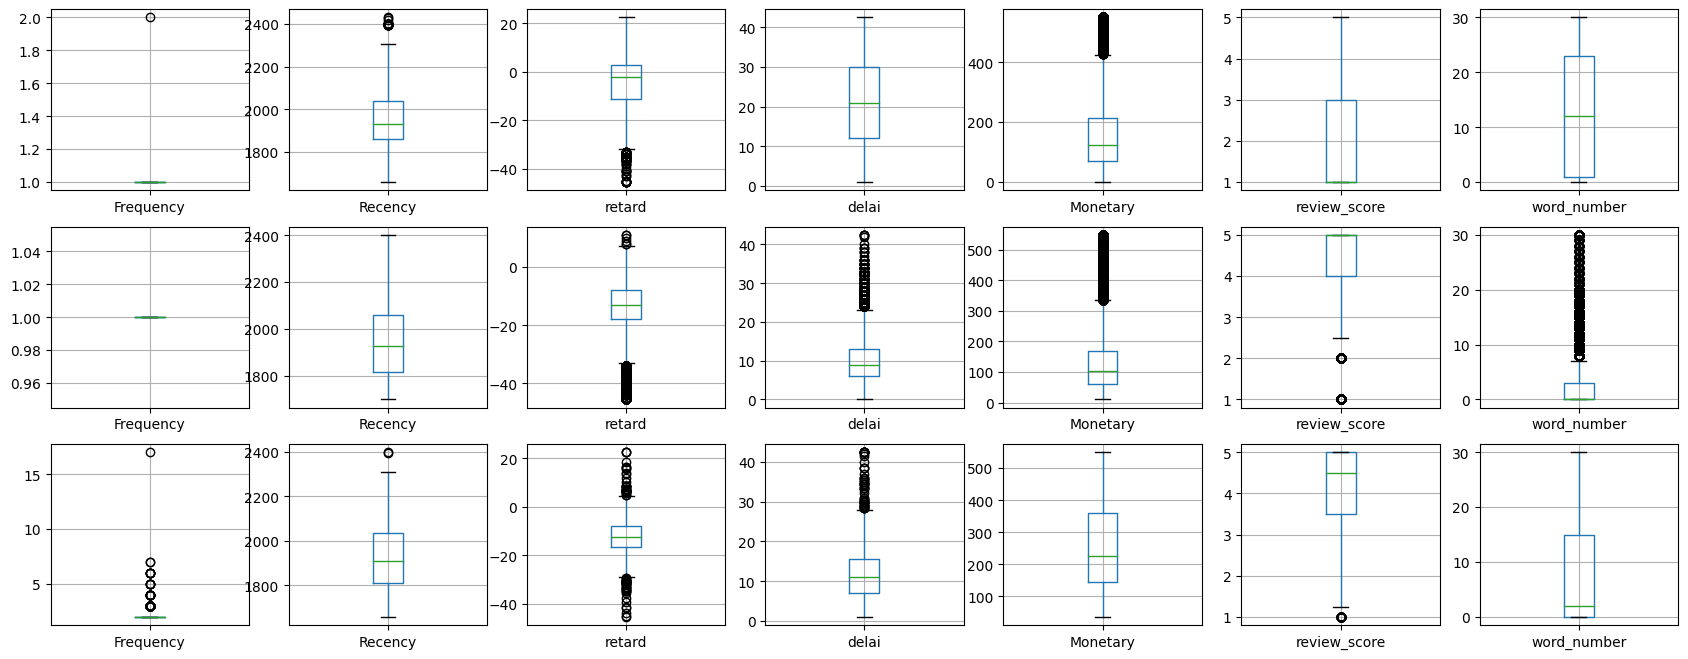

In [45]:
colsTodisplay = getCompCols(df,[predictColName])

fig, axes = plt.subplots(clusterNumber,len(colsTodisplay),figsize=(21, 8))

for cluster in range(clusterNumber):
    for i,el in enumerate(colsTodisplay):
        #print(cluster,i,el)
        df_cluster[cluster].boxplot(el, ax=axes[cluster].flatten()[i])

plt.show()